In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import AutoModel, AutoTokenizer, AutoConfig
import re
import pandas as pd
from tqdm import tqdm
import os
from collections import Counter
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from peft import get_peft_model, LoraConfig, TaskType


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/essay-scoring/balanced_essay_data_2.csv


In [2]:
class DebertaRegressor(nn.Module):
    def __init__(self, model_name="microsoft/deberta-v3-large"):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.deberta = AutoModel.from_pretrained(model_name, config=self.config)
        self.regressor = nn.Linear(self.config.hidden_size, 1)
        self.base_model = self.deberta

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        return (token_embeddings * input_mask_expanded).sum(1) / input_mask_expanded.sum(1)

    def forward(self, input_ids=None, attention_mask=None, **kwargs):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled_output = self.mean_pooling(outputs, attention_mask)
        logits = self.regressor(pooled_output).squeeze(-1)
        return torch.sigmoid(logits)



class EssayDataset(Dataset):
    def __init__(self, texts, scores, tokenizer, weights=None, max_length=512):
        self.texts = texts
        self.scores = scores
        self.weights = weights
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        score = self.scores[idx]

        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        input_ids = tokens["input_ids"].squeeze(0)
        attention_mask = tokens["attention_mask"].squeeze(0)

        item = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "score": torch.tensor(score, dtype=torch.float)
        }

        if self.weights is not None:
            item["weight"] = torch.tensor(self.weights[idx], dtype=torch.float)

        return item




def train_epoch(model, dataloader, optimizer, device):
    model.train()
    all_preds = []
    all_targets = []

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        scores = batch["score"].to(device)

        optimizer.zero_grad()
        predictions = model(input_ids=input_ids, attention_mask=attention_mask)
        weights = batch["weight"].to(device)
        loss = torch.mean(weights * (predictions - scores) ** 2)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        all_preds.extend(predictions.detach().cpu().numpy())
        all_targets.extend(scores.detach().cpu().numpy())

        progress_bar.set_postfix(loss=loss.item())

    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    metrics = {
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    }

    return metrics


def evaluate(model, dataloader, device):
    model.eval()
    predictions_list = []
    targets_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            scores = batch["score"].to(device)

            preds = model(input_ids=input_ids, attention_mask=attention_mask)

            predictions_list.extend(preds.cpu().numpy())
            targets_list.extend(scores.cpu().numpy())

    predictions_array = np.array(predictions_list)
    targets_array = np.array(targets_list)

    mse = mean_squared_error(targets_array, predictions_array)
    mae = mean_absolute_error(targets_array, predictions_array)
    r2 = r2_score(targets_array, predictions_array)

    metrics = {
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    }

    return metrics, predictions_list, targets_list



def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)              
    text = re.sub(r'https?://\S+|www\.\S+', '', text) 
    text = re.sub(r"[^a-z0-9.,!?'\s]", ' ', text)      
    text = re.sub(r'\s+', ' ', text).strip()           
    return text


def load_dataset(scale_scores=True, min_len=30):
    df = pd.read_csv("/kaggle/input/essay-scoring/balanced_essay_data_2.csv") 

    df = df.dropna(subset=['essay', 'score'])
    df = df.drop_duplicates(subset='essay').reset_index(drop=True)
    

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = df[df['essay'].str.strip() != ""]
    df['essay'] = df['essay'].apply(clean_text)
    df = df[df['essay'].str.split().apply(len) >= min_len]
    df['score'] = np.floor(df['score'] * 10) / 10
    weights = compute_score_weights(df['score']).reset_index(drop=True)
    df['weight'] = weights

    return df.reset_index(drop=True)


def save_structured_output(texts, predictions, targets, output_prefix="structured_output"):
    structured_data = []

    for i in range(len(texts)):
        item = {
            "essay_id": i,
            "essay_text": texts[i],
            "predicted_score": round(float(predictions[i]), 2),
            "actual_score": float(targets[i])
        }
        structured_data.append(item)

    
    with open(f"{output_prefix}.json", "w", encoding="utf-8") as f_json:
        json.dump(structured_data, f_json, indent=4)

def compute_score_weights(scores):
    score_counts = scores.value_counts(normalize=True) 
    score_weights = 1.0 / score_counts
    score_weights /= score_weights.sum()
    return scores.map(score_weights)


In [ ]:
df = load_dataset()

In [4]:
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,essay,score,weight
0,do you really think that there is aliens on ma...,0.4,0.124824
1,"in a cowboy who rode the waves , luke had made...",0.2,0.180615
2,venus is really not a planet bc from earth it'...,0.0,0.133081
3,the new technology that allows you to identify...,0.4,0.124824
4,"are driverless cars the next big thing? yes, y...",0.4,0.124824
...,...,...,...
60897,venus is a planet also known as the evening st...,0.0,NaN
60898,"hello , my name is shawn, and i will be arguin...",0.2,NaN
60899,i make a claim for the value of the technology...,0.2,NaN
60900,the author talks about venus being a dangreour...,0.0,NaN


In [5]:
df = df.dropna(subset=['essay', 'score','weight'])

In [6]:
df

,essay,score,weight
0,do you really think that there is aliens on ma...,0.4,0.124824
1,"in a cowboy who rode the waves , luke had made...",0.2,0.180615
2,venus is really not a planet bc from earth it'...,0.0,0.133081
3,the new technology that allows you to identify...,0.4,0.124824
4,"are driverless cars the next big thing? yes, y...",0.4,0.124824
...,...,...,...
60863,although it may seem that there is a face on m...,0.4,0.133081
60864,one time a generic name was assigned to him in...,0.8,0.180615
60865,"a few days after may 24,1976 nasa discovered a...",0.4,0.180615
60866,limting car usage is good because of so many w...,0.2,0.133081


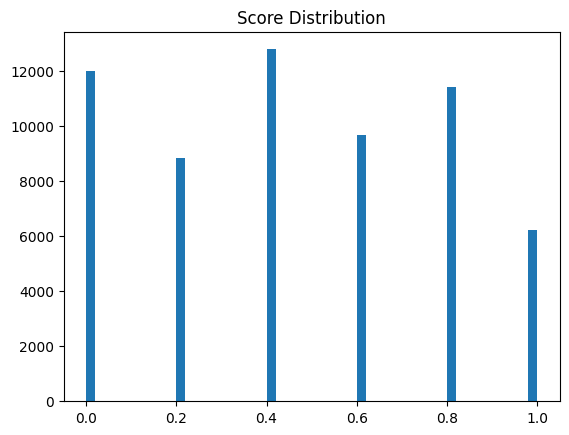

In [7]:
import matplotlib.pyplot as plt
plt.hist(df['score'], bins=50)
plt.title("Score Distribution")
plt.show()


In [8]:
df["score"].value_counts()

score
0.4    12776
0.0    11974
0.8    11423
0.6     9651
0.2     8829
1.0     6215
Name: count, dtype: int64

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [10]:
base_model = DebertaRegressor().to(device)

peft_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query_proj", "key_proj", "value_proj"], 
    modules_to_save=["regressor"] 
)



model = get_peft_model(base_model, peft_config).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

In [11]:
train_texts,test_texts, train_labels, test_labels = train_test_split(
    df["essay"], df["score"],
    test_size=0.2, random_state=42, stratify=df["score"]
)

train_dataset = EssayDataset(train_texts.reset_index(drop=True), train_labels.reset_index(drop=True), tokenizer,df["weight"])
test_dataset = EssayDataset(test_texts.reset_index(drop=True), test_labels.reset_index(drop=True), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

In [13]:
if __name__ == "__main__":
    b_metrics, b_predictions, b_targets = evaluate(base_model, test_loader, device)
    print("Before Training Metrics:", b_metrics)
    for epoch in range(1):
        print(f"Epoch: {epoch+1}")
        metrics = train_epoch(model, train_loader, optimizer, device)
        print("Training Metrics:", metrics)
        a_metrics, a_predictions, a_targets = evaluate(model, test_loader, device)
        print("After Training Metrics:", a_metrics)

Before Training Metrics: {'MSE': 0.12619485, 'MAE': 0.29722437, 'R2': -0.18195444615267986}
Epoch: 1


Training Metrics: {'MSE': 0.030552413, 'MAE': 0.12717074, 'R2': 0.7138277711892231}


After Training Metrics: {'MSE': 0.021391856, 'MAE': 0.10365381, 'R2': 0.7996415986789548}


In [14]:
for epoch in range(1):
    print(f"Epoch: {epoch+1}")
    metrics = train_epoch(model, train_loader, optimizer, device)
    print("Training Metrics:", metrics)
    a_metrics, a_predictions, a_targets = evaluate(model, test_loader, device)
    print("After Training Metrics:", a_metrics)

Epoch: 1


Training Metrics: {'MSE': 0.017572109, 'MAE': 0.09370793, 'R2': 0.8354091028415225}


After Training Metrics: {'MSE': 0.016555635, 'MAE': 0.09152421, 'R2': 0.8449381563201522}


In [15]:
for epoch in range(1):
    print(f"Epoch: {epoch+1}")
    metrics = train_epoch(model, train_loader, optimizer, device)
    print("Training Metrics:", metrics)
    a_metrics, a_predictions, a_targets = evaluate(model, test_loader, device)
    print("After Training Metrics:", a_metrics)

Epoch: 1


Training Metrics: {'MSE': 0.014665449, 'MAE': 0.086263776, 'R2': 0.8626345968287903}


After Training Metrics: {'MSE': 0.015565269, 'MAE': 0.087494865, 'R2': 0.8542140414281317}


In [16]:
from peft import PeftModel

model.save_pretrained("lora_deberta_adapter_final_2")


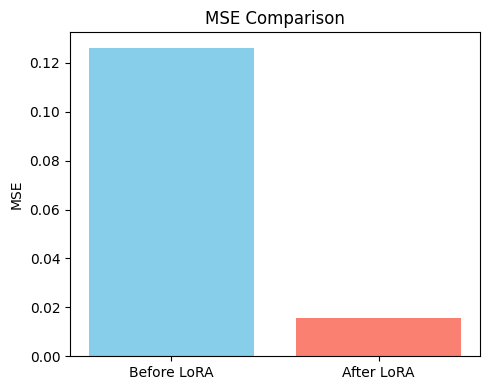

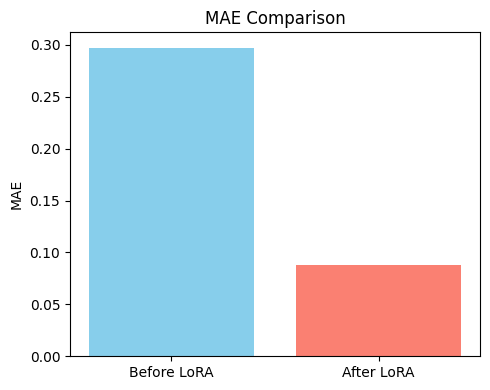

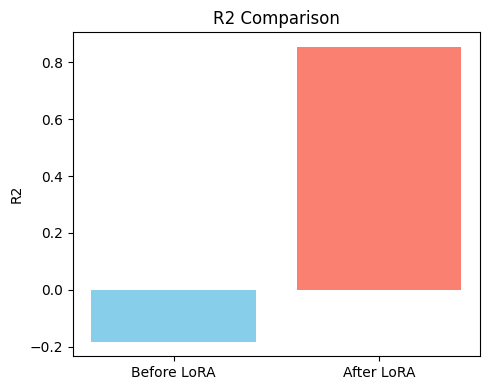

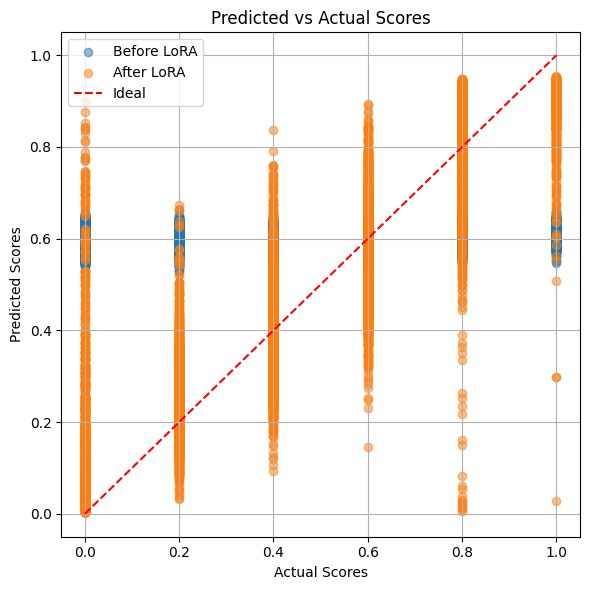

In [17]:
metrics_to_plot = ['MSE', 'MAE', 'R2']
b_values = [b_metrics[m] for m in metrics_to_plot]
a_values = [a_metrics[m] for m in metrics_to_plot]


for i, metric in enumerate(metrics_to_plot):
    plt.figure(figsize=(5, 4))
    plt.bar(['Before LoRA', 'After LoRA'], [b_values[i], a_values[i]], color=['skyblue', 'salmon'])
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(6, 6))
plt.scatter(b_targets, b_predictions, alpha=0.5, label="Before LoRA")
plt.scatter(a_targets, a_predictions, alpha=0.5, label="After LoRA")
min_val = min(min(b_targets), min(a_targets))
max_val = max(max(b_targets), max(a_targets))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal")
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Predicted vs Actual Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
save_structured_output(test_texts.tolist(), a_predictions, a_targets, output_prefix="model_output_V2")

In [ ]:
def predict_feedback(model, tokenizer, text, device, max_length=512):
    model.eval()
    model.to(device)
    text_cleaned = clean_text(text)

    tokens = tokenizer(
        text_cleaned,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True
    )

    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    with torch.no_grad():
        pred = model(input_ids=input_ids, attention_mask=attention_mask)

    predicted_score = pred.item()

    # Feedback logic
    if predicted_score >= 0.6:
        overall = "This essay is strong overall, showing excellent organization, development of ideas, and clarity in expression."
        strengths = "Ideas are well-structured, arguments are persuasive, and language use is mostly mature and accurate."
        improvements = "Polish minor grammar issues and ensure transitions are smooth to reach perfection."
    elif predicted_score >= 0.3:
        overall = "This essay is moderately effective, with some clear ideas but also noticeable issues in structure or grammar."
        strengths = "The essay communicates a clear message and shows effort in supporting ideas with examples."
        improvements = "Focus on improving sentence structure, grammar, and the logical flow between paragraphs."
    else:
        overall = "This essay is underdeveloped and difficult to follow, with significant issues in structure and language."
        strengths = "The attempt to engage with the topic is visible."
        improvements = "Focus on organizing your thoughts clearly, using proper grammar, and fully developing your main ideas."

    return {
        "predicted_score": predicted_score,
        "overall_evaluation": overall,
        "strengths": strengths,
        "areas_for_improvement": improvements
    }


In [ ]:
essay = """
Standardized testing has long been used to measure student achievement, but it fails to capture the full scope of a student’s abilities. 
While some argue that tests provide objective data, they often reduce learning to memorization rather than critical thinking. 
A single test cannot reflect creativity, collaboration, or problem-solving skills—all essential in real-world settings. 
Moreover, standardized exams disproportionately disadvantage students from under-resourced backgrounds, reinforcing existing inequalities. 
Instead of focusing on test scores, schools should adopt a more holistic approach to assessment. 
Project-based learning, portfolios, and teacher evaluations offer more comprehensive insights into student growth. 
Countries like Finland, known for top-performing education systems, have minimized standardized testing and instead emphasize trust in teachers and student-centered learning. 
Their success demonstrates that meaningful education doesn’t need to be driven by exams. 
In conclusion, standardized tests should not define academic success. 
Schools must evolve to measure what truly matters: the ability to think, create, and apply knowledge in diverse contexts.
"""
result = predict_feedback(model, tokenizer, essay, device)
print("Predicted Score:", result['predicted_score'])
print("Overall Evaluation:", result['overall_evaluation'])
print("Strengths:", result['strengths'])
print("Areas for Improvement:", result['areas_for_improvement'])


In [4]:
def generate_feedback_based_on_prediction(predicted_score):
    if predicted_score >= 0.7:
        overall = "This essay is strong overall, showing excellent organization, development of ideas, and clarity in expression."
        strengths = "Ideas are well-structured, arguments are persuasive, and language use is mostly mature and accurate."
        improvements = "Polish minor grammar issues and ensure transitions are smooth to reach perfection."

    elif predicted_score >= 0.5:
        overall = "This essay is fairly effective, with generally clear ideas and good effort in structure."
        strengths = "The essay presents organized thoughts and some persuasive arguments."
        improvements = "Work on refining grammar and strengthening transitions between points."

    elif predicted_score >= 0.3:
        overall = "This essay has potential but needs improvement in structure, clarity, and development."
        strengths = "There are some clear ideas, and an effort to support them is noticeable."
        improvements = "Improve sentence flow, avoid repetition, and develop arguments more fully."

    else:
        overall = "This essay is underdeveloped and difficult to follow, with significant issues in structure and language."
        strengths = "The attempt to engage with the topic is visible."
        improvements = "Focus on organizing your thoughts clearly, using proper grammar, and fully developing your main ideas."

    return {
        "overall_evaluation": overall,
        "strengths": strengths,
        "areas_for_improvement": improvements
    }

with open("model_output_V2.json", "r", encoding="utf-8") as f:
    essays = json.load(f)

for essay in essays:
    pred = essay.get("predicted_score", 0.0)
    essay["feedback"] = generate_feedback_based_on_prediction(pred)

with open("model_final_outputs_2.json", "w", encoding="utf-8") as f:
    json.dump(essays, f, indent=4, ensure_ascii=False)

print("Feedback based on predicted score saved to 'model_final_outputs.json'.")

Feedback based on predicted score saved to 'model_final_outputs.json'.
